In [46]:
%matplotlib inline

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import MSELoss
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [48]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [49]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Sigmoid()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        
        for name, param in self.named_parameters():
            #if 'input_layer' in name and 'bias' in name:
                # nn.init.zeros_(param)
                # print(param)
            print(name,param.size())


    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

  

In [50]:
def fit(model, training_set, num_epochs, optimizer, p,q=2, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_.reshape(-1,1))
                # Item 1. below
                loss = torch.mean(torch.abs((u_pred_.reshape(-1,1 ) - u_train_.reshape(-1,1)))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)

        if verbose:    
            print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [51]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)


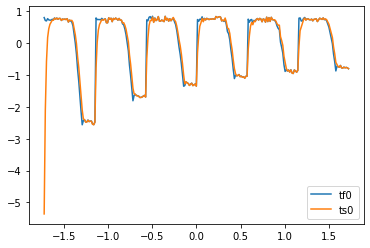

In [52]:
train = pd.read_csv("Task1/Task1/TrainingData.txt")
train_tensor = torch.Tensor(train.values)
t_train = train_tensor[:,0]
t_train = (t_train-torch.mean(t_train))/(torch.std(t_train))
y_train = train_tensor[:,1:]
y_train = (y_train-torch.mean(y_train))/(torch.std(y_train))
n_sample = t_train.shape[0]
training_set = DataLoader(torch.utils.data.TensorDataset(t_train,y_train),batch_size=n_sample,shuffle=False)
plt.plot(t_train,y_train)
plt.legend(["tf0","ts0"])

In [53]:
my_network = NeuralNet(input_dimension=1, output_dimension=2, n_hidden_layers=2, neurons=20)
retrain = 8
# Xavier weight initialization
init_xavier(my_network, retrain)
optimizer = optim.Adam(my_network.parameters(), lr=0.1)
# optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

input_layer.weight torch.Size([20, 1])
input_layer.bias torch.Size([20])
hidden_layers.0.weight torch.Size([20, 20])
hidden_layers.0.bias torch.Size([20])
hidden_layers.1.weight torch.Size([20, 20])
hidden_layers.1.bias torch.Size([20])
output_layer.weight torch.Size([2, 20])
output_layer.bias torch.Size([2])


In [54]:
epochs = 2500
history = fit(my_network, training_set, epochs, optimizer, p=2,verbose=True)

################################  0  ################################
Loss:  1.0244914293289185
################################  1  ################################
Loss:  4.7197394371032715
################################  2  ################################
Loss:  1.3368231058120728
################################  3  ################################
Loss:  1.3379684686660767
################################  4  ################################
Loss:  1.9923866987228394
################################  5  ################################
Loss:  1.8880348205566406
################################  6  ################################
Loss:  1.47104012966156
################################  7  ################################
Loss:  1.1374865770339966
################################  8  ################################
Loss:  1.0206552743911743
################################  9  ################################
Loss:  1.056349754333496
################################  10  #####

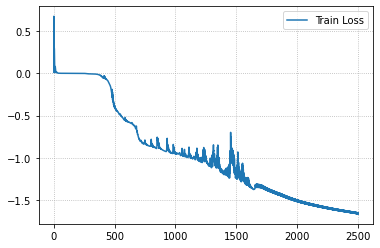

In [55]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,epochs+1), np.log10(history), label="Train Loss")
plt.legend()
plt.show()

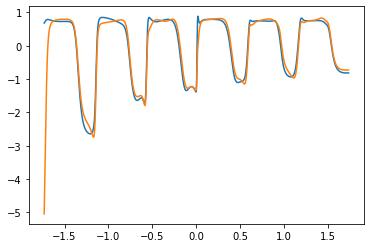

In [56]:
test = pd.read_csv("Task1/Task1/TestingData.txt")
test_tensor = torch.Tensor(test.values)
t_test = (test_tensor-torch.mean(test_tensor))/torch.std(test_tensor)
y_test_pred = my_network(t_test.reshape(-1,1))
plt.plot(t_test,y_test_pred.detach())
plt.show()